In [16]:
import os
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import timedelta

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import GroupShuffleSplit, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.impute import SimpleImputer

# Statsmodels
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats

In [3]:
DATA1 = "cleaned_data/dataset1_clean.csv"
DATA2 = "cleaned_data/dataset2_clean.csv"

d1 = pd.read_csv(DATA1)
d2 = pd.read_csv(DATA2)

OUTPUT_DIR = "./investigation_b_outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [4]:
print("Dataset1 shape:", d1.shape)
print("Dataset2 shape:", d2.shape)
display(d1.head())
display(d1.dtypes)
display(d2.head())
display(d2.dtypes)

Dataset1 shape: (906, 14)
Dataset2 shape: (2123, 9)


,Unnamed: 0,start_time,bat_landing_to_food,habit,rat_period_start,rat_period_end,seconds_after_rat_arrival,risk,reward,month,sunset_time,hours_after_sunset,season,period_time
0,0,2017-12-30 18:37:00,16.000000,rat,2017-12-30 18:35:00,2017-12-30 18:38:00,108,1,0,0,2017-12-30 16:45:00,1.870833,0,2017-12-30 18:30:00
1,1,2017-12-30 19:51:00,0.074016,fast,2017-12-30 19:50:00,2017-12-30 19:55:00,17,0,1,0,2017-12-30 16:45:00,3.100833,0,2017-12-30 19:30:00
2,2,2017-12-30 19:51:00,4.000000,fast,2017-12-30 19:50:00,2017-12-30 19:55:00,41,0,1,0,2017-12-30 16:45:00,3.107500,0,2017-12-30 19:30:00
3,3,2017-12-30 19:52:00,10.000000,rat,2017-12-30 19:50:00,2017-12-30 19:55:00,111,1,0,0,2017-12-30 16:45:00,3.126944,0,2017-12-30 19:30:00
4,4,2017-12-30 19:54:00,15.000000,rat,2017-12-30 19:50:00,2017-12-30 19:55:00,194,1,0,0,2017-12-30 16:45:00,3.150000,0,2017-12-30 19:30:00


Unnamed: 0                     int64
start_time                    object
bat_landing_to_food          float64
habit                         object
rat_period_start              object
rat_period_end                object
seconds_after_rat_arrival      int64
risk                           int64
reward                         int64
month                          int64
sunset_time                   object
hours_after_sunset           float64
season                         int64
period_time                   object
dtype: object

,Unnamed: 0,time,month,hours_after_sunset,bat_landing_number,food_availability,rat_minutes,rat_arrival_number,period_time
0,0,2017-12-26 16:13:00,0,-0.5,20,4.000000,0.0,0,2017-12-26 16:00:00
1,1,2017-12-26 16:43:00,0,0.0,28,4.000000,0.0,0,2017-12-26 16:30:00
2,2,2017-12-26 17:13:00,0,0.5,25,4.000000,0.0,0,2017-12-26 17:00:00
3,3,2017-12-26 17:43:00,0,1.0,71,4.000000,0.0,0,2017-12-26 17:30:00
4,4,2017-12-26 18:13:00,0,1.5,44,3.753857,0.0,0,2017-12-26 18:00:00


Unnamed: 0              int64
time                   object
month                   int64
hours_after_sunset    float64
bat_landing_number      int64
food_availability     float64
rat_minutes           float64
rat_arrival_number      int64
period_time            object
dtype: object

In [5]:
# season check for y1 presence
if 'season' in d1.columns and 'bat_landing_to_food' in d1.columns:
    season_summary = d1.groupby('season')['bat_landing_to_food'].agg(['count','mean','std','median','min','max'])
    print("Seasonal summary for bat_landing_to_food:")
    display(season_summary)

Seasonal summary for bat_landing_to_food:


,count,mean,std,median,min,max
season,,,,,,
0,151,5.996576,13.500745,2.0,0.010696,148.5
1,755,12.018979,22.173432,4.0,0.010238,148.5


Feature Engineering

In [6]:
df1 = d1.copy()
df2 = d2.copy()

# Building y2 on 30-minutes window dataset, then meerge onto landings
if 'bat_landing_number' in df2.columns and 'rat_minutes' in df2.columns:
    df2['bat_activity_intensity'] = np.log1p(df2['bat_landing_number'] / (df2['rat_minutes'] + 1.0))
else:
    df2['bat_activity_intensity'] = np.nan

In [7]:
for col in ['start_time', 'time']:
    if col in df1.columns:
        df1[col] = pd.to_datetime(df1[col], errors='coerce')
    if col in df2.columns:
        df2[col] = pd.to_datetime(df2[col], errors='coerce')

# Drop rows with missing merge keys
df1 = df1.dropna(subset=['start_time']).copy()
df2 = df2.dropna(subset=['time']).copy()

# Sort both datasets by merge keys
df1 = df1.sort_values('start_time').reset_index(drop=True)
df2 = df2.sort_values('time').reset_index(drop=True)

# Perform time-aware merge (backward: find the last 30-min window before bat event)
merged = pd.merge_asof(
    df1,
    df2,
    left_on='start_time',
    right_on='time',
    direction='backward',
    tolerance=pd.Timedelta(hours=6)
)

# Merge-asof: bring most recent 30-min context to each bat landing
if 'start_time' in df1.columns and 'time' in df2.columns:
    df1 = df1.sort_values('start_time')
    df2 = df2.sort_values('time')
    merged = pd.merge_asof(
        df1, df2, left_on='start_time', right_on='time',
        direction='backward', tolerance=pd.Timedelta(hours=6)
    )
else:
    merged = df1.copy()

In [8]:
# Food scarcity (scaled to [0,1] if possible)
if 'food_availability' in merged.columns:
    fa = merged['food_availability'].astype(float)
    if fa.notna().any():
        fa_min, fa_max = fa.min(), fa.max()
        if pd.notna(fa_min) and pd.notna(fa_max) and fa_max > fa_min:
            merged['food_scaled_01'] = (fa - fa_min) / (fa_max - fa_min)
        else:
            merged['food_scaled_01'] = fa
    else:
        merged['food_scaled_01'] = np.nan
    merged['food_scarcity'] = 1 - merged['food_scaled_01']
else:
    merged['food_scarcity'] = np.nan

In [9]:
# Night grouping for leakage-free splitting
if 'start_time' in merged.columns:
    merged['night_id'] = merged['start_time'].dt.date.astype('string')
else:
    merged['night_id'] = "unknown"


# Categoricals
if 'habit' in merged.columns:
    merged['habit'] = merged['habit'].astype('string')

# Keep only rows with y₁ present
merged = merged[merged['bat_landing_to_food'].notna()].reset_index(drop=True)

print("Merged shape:", merged.shape)
display(merged.head())

Merged shape: (906, 27)


,Unnamed: 0_x,start_time,bat_landing_to_food,habit,rat_period_start,rat_period_end,seconds_after_rat_arrival,risk,reward,month_x,...,hours_after_sunset_y,bat_landing_number,food_availability,rat_minutes,rat_arrival_number,period_time_y,bat_activity_intensity,food_scaled_01,food_scarcity,night_id
0,16,2017-12-26 20:57:00,1.0,Unknown,2017-12-26 20:53:00,2017-12-26 20:58:00,239,0,0,0,...,4.0,51,2.968874,1.283333,2,2017-12-26 20:30:00,3.149987,0.742218,0.257782,2017-12-26
1,15,2017-12-26 20:57:00,5.0,Unknown,2017-12-26 20:53:00,2017-12-26 20:58:00,199,0,0,0,...,4.0,51,2.968874,1.283333,2,2017-12-26 20:30:00,3.149987,0.742218,0.257782,2017-12-26
2,9,2017-12-26 21:24:00,3.0,fast,2017-12-26 21:22:00,2017-12-26 21:27:00,121,0,1,0,...,4.5,53,2.561404,4.866667,1,2017-12-26 21:00:00,2.305988,0.640351,0.359649,2017-12-26
3,7,2017-12-26 21:24:00,15.0,rat,2017-12-26 21:22:00,2017-12-26 21:27:00,88,1,0,0,...,4.5,53,2.561404,4.866667,1,2017-12-26 21:00:00,2.305988,0.640351,0.359649,2017-12-26
4,8,2017-12-26 21:24:00,6.0,pick,2017-12-26 21:22:00,2017-12-26 21:27:00,113,0,1,0,...,4.5,53,2.561404,4.866667,1,2017-12-26 21:00:00,2.305988,0.640351,0.359649,2017-12-26


EDA - Distributions & Tests

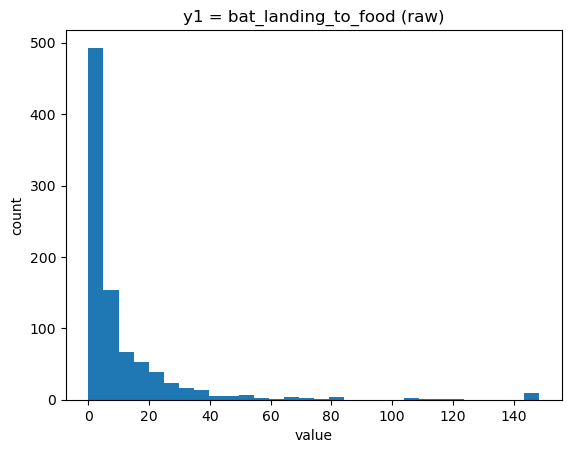

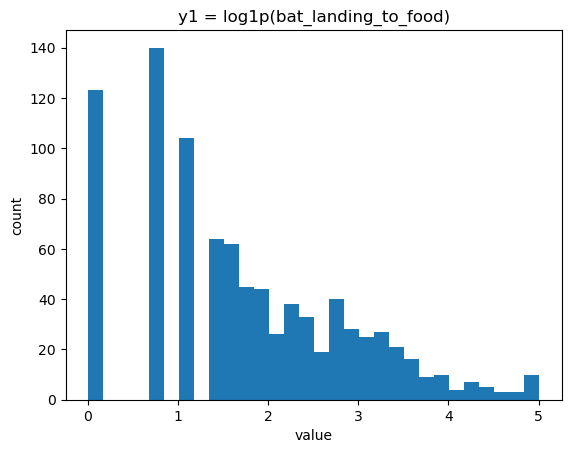

In [10]:
def plot_hist_series(series, title, bins=30):
    plt.figure()
    s = series.dropna().values
    if len(s) == 0:
        print(f"No data for {title}")
        return
    plt.hist(s, bins=bins)
    plt.title(title)
    plt.xlabel("value")
    plt.ylabel("count")
    plt.show()

# y1 raw and log1p
y1_raw = merged['bat_landing_to_food'].astype(float)
plot_hist_series(y1_raw, "y1 = bat_landing_to_food (raw)")
plot_hist_series(np.log1p(y1_raw), "y1 = log1p(bat_landing_to_food)")

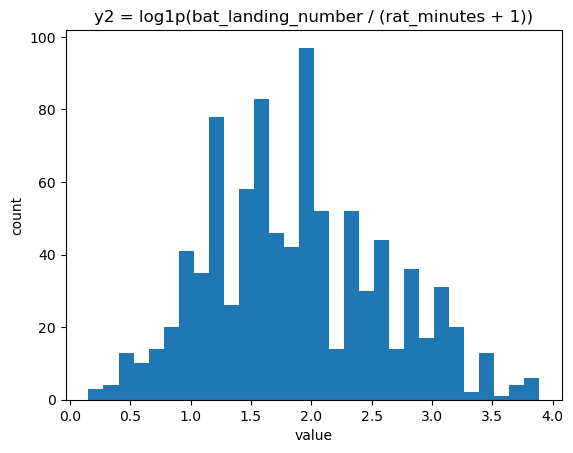

In [11]:
# y2 distribution
if 'bat_activity_intensity' not in merged.columns:
    merged['bat_activity_intensity'] = np.nan
plot_hist_series(merged['bat_activity_intensity'], "y2 = log1p(bat_landing_number / (rat_minutes + 1))")

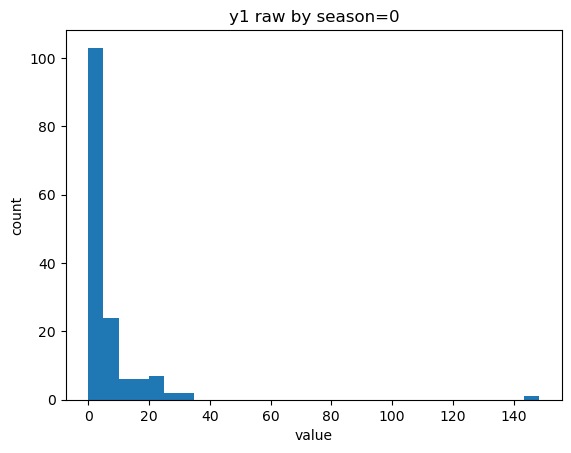

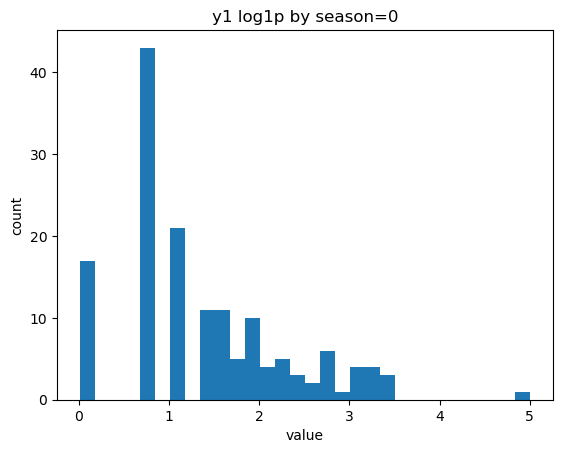

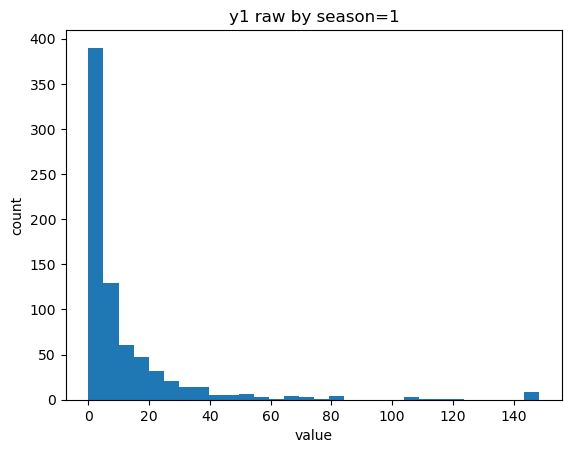

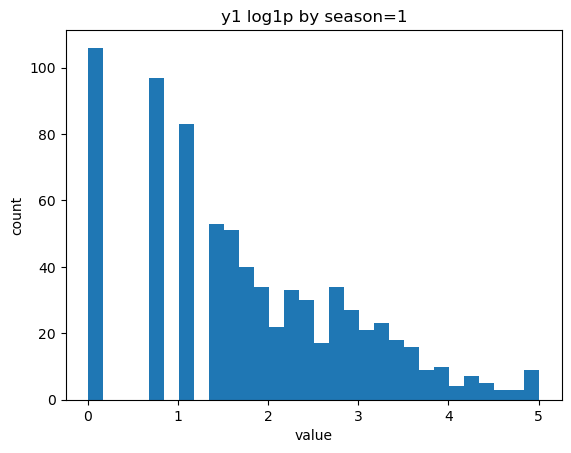

In [12]:
# Seasonal comparisons — histograms
if 'season' in merged.columns:
    for szn in sorted(merged['season'].dropna().unique()):
        sub = merged.loc[merged['season']==szn, 'bat_landing_to_food'].astype(float)
        plot_hist_series(sub, f"y1 raw by season={szn}")
        plot_hist_series(np.log1p(sub), f"y1 log1p by season={szn}")

In [13]:
# Basic correlations (numeric only) — multicollinearity check start
num_cols = merged.select_dtypes(include=[np.number]).columns.tolist()
corr = merged[num_cols].corr()
# corr_path = os.path.join(OUTPUT_DIR, "correlation_matrix.csv")
# corr.to_csv(corr_path)
# print("Saved correlation matrix to:", corr_path)
display(corr.round(3))

,Unnamed: 0_x,bat_landing_to_food,seconds_after_rat_arrival,risk,reward,month_x,hours_after_sunset_x,season,Unnamed: 0_y,month_y,hours_after_sunset_y,bat_landing_number,food_availability,rat_minutes,rat_arrival_number,bat_activity_intensity,food_scaled_01,food_scarcity
Unnamed: 0_x,1.000,0.150,0.147,0.025,0.037,0.831,0.072,0.645,0.841,0.825,0.077,-0.445,0.079,0.247,0.026,-0.437,0.079,-0.079
bat_landing_to_food,0.150,1.000,0.040,0.205,-0.008,0.134,-0.039,0.106,0.133,0.134,-0.042,-0.091,0.063,0.080,0.062,-0.110,0.063,-0.063
seconds_after_rat_arrival,0.147,0.040,1.000,0.022,-0.024,0.133,0.077,0.140,0.105,0.140,0.071,-0.140,0.035,0.488,-0.011,-0.360,0.035,-0.035
risk,0.025,0.205,0.022,1.000,-0.625,0.005,-0.059,-0.061,0.031,0.001,-0.058,0.027,0.049,-0.045,0.035,0.045,0.049,-0.049
reward,0.037,-0.008,-0.024,-0.625,1.000,0.073,0.052,0.152,0.093,0.078,0.052,-0.047,-0.043,0.093,-0.133,-0.091,-0.043,0.043
month_x,0.831,0.134,0.133,0.005,0.073,1.000,0.045,0.881,0.944,0.997,0.050,-0.224,0.000,0.290,-0.060,-0.333,0.000,-0.000
hours_after_sunset_x,0.072,-0.039,0.077,-0.059,0.052,0.045,1.000,-0.005,0.056,0.047,0.998,-0.188,-0.694,0.111,0.027,-0.211,-0.694,0.694
season,0.645,0.106,0.140,-0.061,0.152,0.881,-0.005,1.000,0.842,0.882,-0.001,-0.125,0.023,0.355,-0.202,-0.313,0.023,-0.023
Unnamed: 0_y,0.841,0.133,0.105,0.031,0.093,0.944,0.056,0.842,1.000,0.943,0.060,-0.256,-0.014,0.256,-0.065,-0.334,-0.014,0.014
month_y,0.825,0.134,0.140,0.001,0.078,0.997,0.047,0.882,0.943,1.000,0.052,-0.227,-0.005,0.300,-0.056,-0.341,-0.005,0.005


In [14]:
# Inferential tests (EDA HD-level): seasonal differences for y1 and y2
if 'season' in merged.columns:
    seasons = sorted(merged['season'].dropna().unique())
    if len(seasons) == 2:
        s0 = merged.loc[merged['season']==seasons[0], 'bat_landing_to_food'].dropna().values
        s1 = merged.loc[merged['season']==seasons[1], 'bat_landing_to_food'].dropna().values
        if len(s0)>10 and len(s1)>10:
            tstat, pval = stats.ttest_ind(np.log1p(s0), np.log1p(s1), equal_var=False)
            print(f"T-test (log y1) season {seasons[0]} vs {seasons[1]}: t={tstat:.3f}, p={pval:.4g}")
        # y2
        if 'bat_activity_intensity' in merged.columns:
            y2s0 = merged.loc[merged['season']==seasons[0], 'bat_activity_intensity'].dropna().values
            y2s1 = merged.loc[merged['season']==seasons[1], 'bat_activity_intensity'].dropna().values
            if len(y2s0)>10 and len(y2s1)>10:
                t2, p2 = stats.ttest_ind(y2s0, y2s1, equal_var=False)
                print(f"T-test (y2) season {seasons[0]} vs {seasons[1]}: t={t2:.3f}, p={p2:.4g}")

T-test (log y1) season 0 vs 1: t=-4.524, p=9.277e-06
T-test (y2) season 0 vs 1: t=8.593, p=3.024e-15


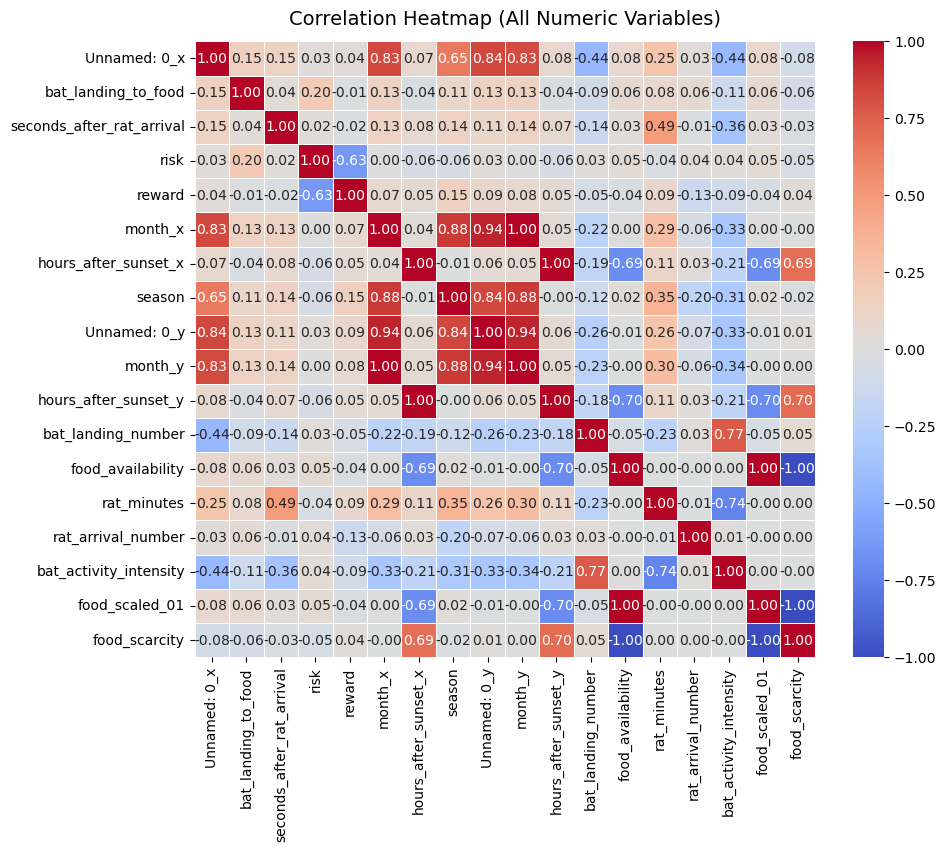

/var/folders/gk/3lnnfsp51hs7txpqd7wtw5840000gn/T/ipykernel_10560/3784616509.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='season', y='bat_landing_to_food', data=merged, palette='pastel')


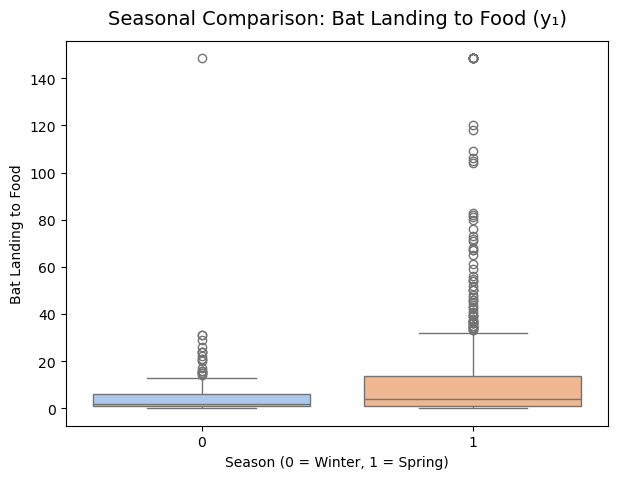

/var/folders/gk/3lnnfsp51hs7txpqd7wtw5840000gn/T/ipykernel_10560/3784616509.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='season', y='bat_activity_intensity', data=merged, palette='pastel')


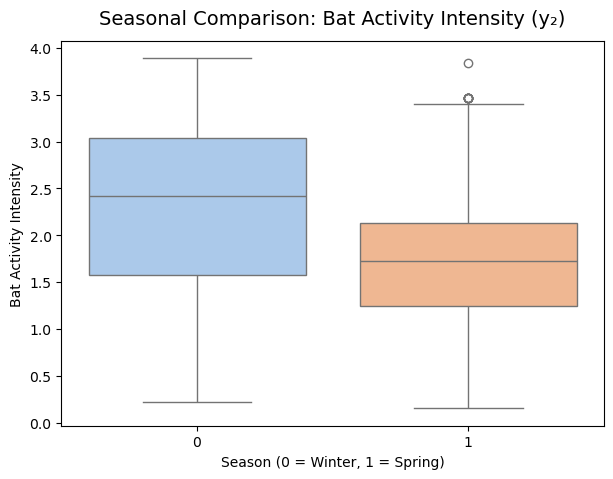

In [15]:
# Correlation Heatmap (using numeric variables only)
num_cols = merged.select_dtypes(include=[np.number]).columns
corr = merged[num_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap (All Numeric Variables)", fontsize=14, pad=12)
plt.show()

# Seasonal Boxplots for y1 and y2

# y1: bat_landing_to_food
plt.figure(figsize=(7, 5))
sns.boxplot(x='season', y='bat_landing_to_food', data=merged, palette='pastel')
plt.title("Seasonal Comparison: Bat Landing to Food (y₁)", fontsize=14, pad=12)
plt.xlabel("Season (0 = Winter, 1 = Spring)")
plt.ylabel("Bat Landing to Food")
plt.show()

# y2: bat_activity_intensity
plt.figure(figsize=(7, 5))
sns.boxplot(x='season', y='bat_activity_intensity', data=merged, palette='pastel')
plt.title("Seasonal Comparison: Bat Activity Intensity (y₂)", fontsize=14, pad=12)
plt.xlabel("Season (0 = Winter, 1 = Spring)")
plt.ylabel("Bat Activity Intensity")
plt.show()


Utility — Metrics, Splits, VIF

In [14]:
def evaluate_regression(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    rmse = math.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    return {"R2": r2, "RMSE": rmse, "MAE": mae}

def grouped_train_val_test_split(df, group_col, test_size=0.15, val_size=0.15, random_state=42):
    """Split by groups (e.g., night_id) with no leakage between train/val/test."""
    groups = df[group_col]
    gss = GroupShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
    train_val_idx, test_idx = next(gss.split(df, groups=groups))
    df_train_val = df.iloc[train_val_idx].copy()
    df_test = df.iloc[test_idx].copy()
    # Now split train_val into train and val
    groups_tv = df_train_val[group_col]
    val_ratio = val_size / (1 - test_size)
    gss2 = GroupShuffleSplit(n_splits=1, test_size=val_ratio, random_state=random_state)
    train_idx2, val_idx2 = next(gss2.split(df_train_val, groups=groups_tv))
    df_train = df_train_val.iloc[train_idx2].copy()
    df_val = df_train_val.iloc[val_idx2].copy()
    return df_train, df_val, df_test

def compute_vif(X_df):
    """Compute VIF on numeric features (rows with NaNs dropped)."""
    X = X_df.dropna(axis=0)
    if X.shape[0] < 10 or X.shape[1] < 2:
        return pd.DataFrame({"feature": X.columns, "VIF": np.nan})
    X_const = sm.add_constant(X)
    vifs = []
    for i, col in enumerate(X.columns):
        try:
            v = variance_inflation_factor(X_const.values, i+1)
        except Exception:
            v = np.nan
        vifs.append(v)
    return pd.DataFrame({"feature": X.columns, "VIF": vifs})

Features & Pipelines (OLS/Ridge/Lasso)

In [15]:
# Select predictors
numeric_features = [c for c in ['rat_minutes','rat_arrival_number','bat_landing_number',
                                'food_availability','hours_after_sunset','food_scarcity']
                    if c in merged.columns]

categorical_features = [c for c in ['habit','month'] if c in merged.columns]

# Drop any accidental leakage columns if present
for drop_col in ['bat_landing_to_food','reward','risk']:
    if drop_col in numeric_features:
        numeric_features.remove(drop_col)

In [16]:
# Preprocess blocks
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocess = ColumnTransformer(transformers=[
    ("num", numeric_transformer, numeric_features),
    ("cat", categorical_transformer, categorical_features)
], remainder="drop")

In [17]:
# Models
ols = LinearRegression()
ridge = Ridge(random_state=42)
lasso = Lasso(random_state=42, max_iter=10000)

ridge_grid = {"model__alpha": [0.01, 0.1, 1.0, 5.0, 10.0, 50.0]}
lasso_grid = {"model__alpha": [0.0005, 0.001, 0.005, 0.01, 0.05, 0.1]}

def build_pipeline(model):
    return Pipeline(steps=[
        ("preprocess", preprocess),
        ("model", model)
    ])

In [18]:
def fit_and_eval(df_train, df_val, df_test, y_col):
    """Fit OLS, Ridge, Lasso on given y, return metrics and fitted models."""
    results = []
    X_train = df_train.copy()
    y_train = np.log1p(X_train[y_col].astype(float))
    X_val = df_val.copy()
    y_val = np.log1p(X_val[y_col].astype(float))
    X_test = df_test.copy()
    y_test = np.log1p(X_test[y_col].astype(float))

    # OLS
    pipe_ols = build_pipeline(ols)
    pipe_ols.fit(X_train, y_train)
    y_pred_test = pipe_ols.predict(X_test)
    res = evaluate_regression(y_test, y_pred_test)
    res.update({"Model":"OLS"})
    results.append(res)

    # Ridge (simple 3-fold CV on train only)
    pipe_ridge = build_pipeline(ridge)
    gs_ridge = GridSearchCV(pipe_ridge, ridge_grid, scoring="neg_mean_squared_error", cv=3, n_jobs=-1)
    gs_ridge.fit(X_train, y_train)
    best_ridge = gs_ridge.best_estimator_
    y_pred_test = best_ridge.predict(X_test)
    res = evaluate_regression(y_test, y_pred_test)
    res.update({"Model":f"Ridge(alpha={gs_ridge.best_params_['model__alpha']})"})
    results.append(res)

    # Lasso
    pipe_lasso = build_pipeline(lasso)
    gs_lasso = GridSearchCV(pipe_lasso, lasso_grid, scoring="neg_mean_squared_error", cv=3, n_jobs=-1)
    gs_lasso.fit(X_train, y_train)
    best_lasso = gs_lasso.best_estimator_
    y_pred_test = best_lasso.predict(X_test)
    res = evaluate_regression(y_test, y_pred_test)
    res.update({"Model":f"Lasso(alpha={gs_lasso.best_params_['model__alpha']})"})
    results.append(res)

    # Extract coefficient table from best ridge (standardized effects for interpretation)
    def extract_coefs(pipeline):
        num_names = numeric_features
        if categorical_features:
            cat_encoder = pipeline.named_steps['preprocess'].named_transformers_['cat'].named_steps['onehot']
            cat_names = cat_encoder.get_feature_names_out(categorical_features).tolist()
        else:
            cat_names = []
        feature_names = list(num_names) + cat_names
        coefs = pipeline.named_steps['model'].coef_
        return pd.DataFrame({"feature": feature_names, "coef": coefs}).sort_values("coef", ascending=False)

    coef_ridge = extract_coefs(best_ridge)
    return pd.DataFrame(results), best_ridge, best_lasso, pipe_ols, coef_ridge

Seasonal Models - y1 = bat_landing_to_food

In [19]:

metrics_y1_list = []
models_y1 = {}
coefs_y1 = {}

for szn in sorted(merged['season'].dropna().unique()):
    df_s = merged.loc[merged['season']==szn].copy()
    df_s = df_s[df_s['bat_landing_to_food'].notna()].copy()
    if df_s.shape[0] < 50:
        print(f"Warning: few rows in season={szn}: {df_s.shape[0]}")
    # Split by night_id to avoid leakage
    df_train, df_val, df_test = grouped_train_val_test_split(df_s, group_col='night_id',
                                                             test_size=0.15, val_size=0.15, random_state=42)
    mdf, ridge_model, lasso_model, ols_model, coef_ridge = fit_and_eval(df_train, df_val, df_test,
                                                                        y_col='bat_landing_to_food')
    mdf.insert(0, "Season", szn)
    mdf.insert(1, "Y", "y1_log1p_bat_landing_to_food")
    metrics_y1_list.append(mdf)
    models_y1[szn] = {"ridge": ridge_model, "lasso": lasso_model, "ols": ols_model,
                      "splits": (df_train, df_val, df_test)}
    coefs_y1[szn] = coef_ridge

metrics_y1 = pd.concat(metrics_y1_list, ignore_index=True)
print("Test metrics for y1:")
display(metrics_y1)

Test metrics for y1:


,Season,Y,R2,RMSE,MAE,Model
0,0,y1_log1p_bat_landing_to_food,0.211183,0.804819,0.674943,OLS
1,0,y1_log1p_bat_landing_to_food,0.001180,0.905636,0.778721,Ridge(alpha=50.0)
2,0,y1_log1p_bat_landing_to_food,-0.087080,0.944802,0.810134,Lasso(alpha=0.1)
3,1,y1_log1p_bat_landing_to_food,0.205639,0.975927,0.733591,OLS
4,1,y1_log1p_bat_landing_to_food,0.226867,0.962798,0.725111,Ridge(alpha=5.0)
5,1,y1_log1p_bat_landing_to_food,0.241419,0.953694,0.716898,Lasso(alpha=0.01)


Seasonal Models - y2 = bat_activity_intensity

In [20]:
metrics_y2_list = []
models_y2 = {}
coefs_y2 = {}

for szn in sorted(merged['season'].dropna().unique()):
    df_s = merged.loc[merged['season']==szn].copy()
    df_s = df_s[df_s['bat_activity_intensity'].notna()].copy()
    if df_s.shape[0] < 50:
        print(f"Warning: few y2 rows in season={szn}: {df_s.shape[0]}")
        if df_s.shape[0] == 0:
            continue
    df_train, df_val, df_test = grouped_train_val_test_split(df_s, group_col='night_id',
                                                             test_size=0.15, val_size=0.15, random_state=42)
    mdf, ridge_model, lasso_model, ols_model, coef_ridge = fit_and_eval(df_train, df_val, df_test,
                                                                        y_col='bat_activity_intensity')
    mdf.insert(0, "Season", szn)
    mdf.insert(1, "Y", "y2_bat_activity_intensity")
    metrics_y2_list.append(mdf)
    models_y2[szn] = {"ridge": ridge_model, "lasso": lasso_model, "ols": ols_model,
                      "splits": (df_train, df_val, df_test)}
    coefs_y2[szn] = coef_ridge

if metrics_y2_list:
    metrics_y2 = pd.concat(metrics_y2_list, ignore_index=True)
    print("Test metrics for y2:")
    display(metrics_y2)
else:
    print("y2 had insufficient data after merge; skipped modelling.")


Test metrics for y2:


,Season,Y,R2,RMSE,MAE,Model
0,0,y2_bat_activity_intensity,0.745017,0.083696,0.053558,OLS
1,0,y2_bat_activity_intensity,0.767591,0.079905,0.055494,Ridge(alpha=10.0)
2,0,y2_bat_activity_intensity,0.673241,0.094746,0.070745,Lasso(alpha=0.05)
3,1,y2_bat_activity_intensity,0.896886,0.088632,0.072204,OLS
4,1,y2_bat_activity_intensity,0.897319,0.088446,0.072067,Ridge(alpha=50.0)
5,1,y2_bat_activity_intensity,0.903784,0.085616,0.068632,Lasso(alpha=0.01)


Diagnostics — VIF & Residual Checks


VIF (y1, season=1)


/opt/anaconda3/envs/bat-vs-rat/lib/python3.11/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,feature,VIF
0,rat_minutes,1.056968
1,rat_arrival_number,1.070953
2,bat_landing_number,1.020294
3,food_availability,inf
4,food_scarcity,inf


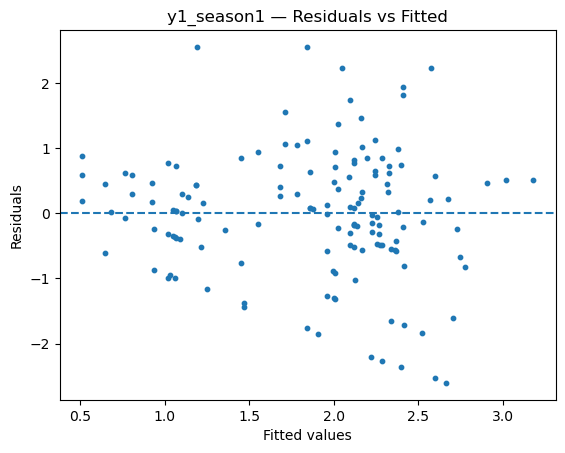

Saved: ./investigation_b_outputs/y1_season1_resid_vs_fitted.png


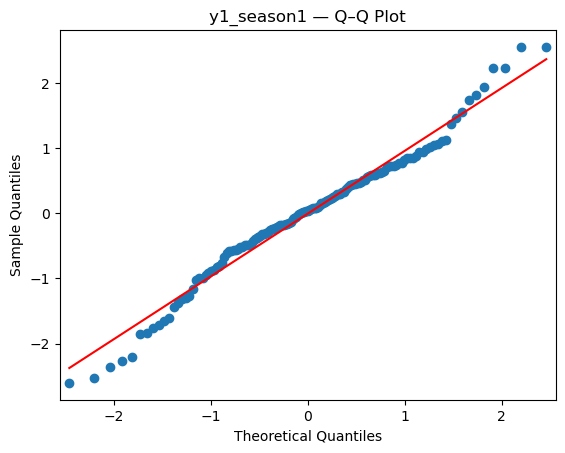

Saved: ./investigation_b_outputs/y1_season1_qq.png

VIF (y2, season=0)


/opt/anaconda3/envs/bat-vs-rat/lib/python3.11/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,feature,VIF
0,rat_minutes,1.300085
1,rat_arrival_number,1.321400
2,bat_landing_number,1.424355
3,food_availability,inf
4,food_scarcity,inf


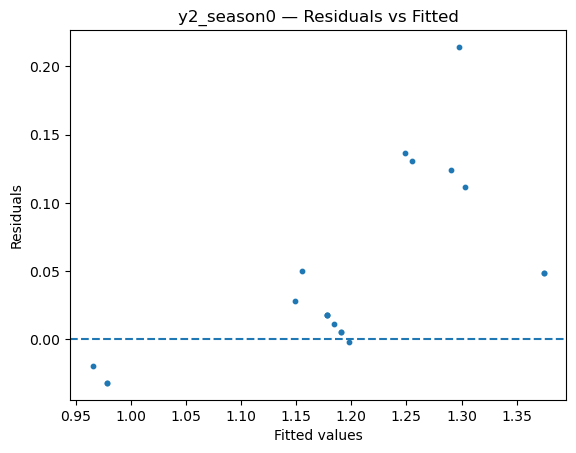

Saved: ./investigation_b_outputs/y2_season0_resid_vs_fitted.png


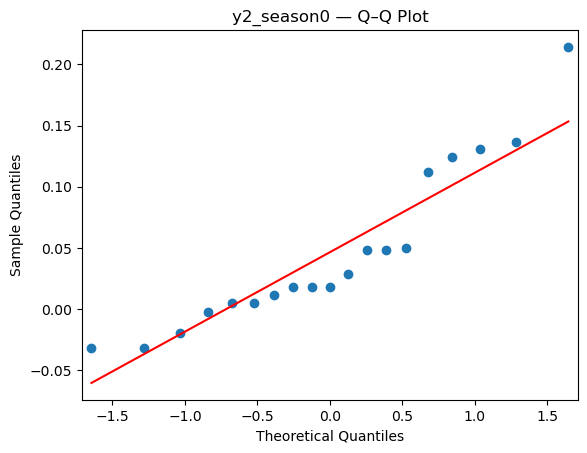

Saved: ./investigation_b_outputs/y2_season0_qq.png


In [22]:
def compute_vif_numeric(df_numeric: pd.DataFrame) -> pd.DataFrame:
    """Compute VIF on numeric features (rows with NaNs dropped)."""
    X = df_numeric.dropna(axis=0)
    if X.shape[0] < 10 or X.shape[1] < 2:
        return pd.DataFrame({"feature": X.columns, "VIF": np.nan})
    X_const = sm.add_constant(X)
    vifs = []
    for i, _ in enumerate(X.columns):
        try:
            v = variance_inflation_factor(X_const.values, i+1)
        except Exception:
            v = np.nan
        vifs.append(v)
    return pd.DataFrame({"feature": X.columns, "VIF": vifs})

def get_numeric_block(df: pd.DataFrame, numeric_feature_list):
    cols = [c for c in numeric_feature_list if c in df.columns]
    num_df = df[cols].copy()
    if len(cols) > 0:
        num_df = num_df.fillna(num_df.median(numeric_only=True))
    return num_df

def plot_resid_and_qq(y_true, y_pred, title_prefix: str):
    resid = y_true - y_pred

    # Residuals vs Fitted
    plt.figure()
    plt.scatter(y_pred, resid, s=10)
    plt.axhline(0, linestyle="--")
    plt.xlabel("Fitted values")
    plt.ylabel("Residuals")
    plt.title(f"{title_prefix} — Residuals vs Fitted")
    path1 = os.path.join(OUTPUT_DIR, f"{title_prefix.replace(' ', '_')}_resid_vs_fitted.png")
    plt.savefig(path1, dpi=150, bbox_inches='tight')
    plt.show()
    print("Saved:", path1)

    # Q–Q plot
    sm.qqplot(resid, line='s')
    plt.title(f"{title_prefix} — Q–Q Plot")
    path2 = os.path.join(OUTPUT_DIR, f"{title_prefix.replace(' ', '_')}_qq.png")
    plt.savefig(path2, dpi=150, bbox_inches='tight')
    plt.show()
    print("Saved:", path2)

# ---------------------------
# y1, season = 1  (Spring)
# ---------------------------
if 'models_y1' in globals() and 1 in models_y1:
    pack = models_y1[1]
    ridge_model = pack['ridge']
    df_train, df_val, df_test = pack['splits']

    # VIF on train (numeric predictors only)
    num_df = get_numeric_block(df_train, numeric_features)
    print("\nVIF (y1, season=1)")
    display(compute_vif_numeric(num_df))

    # Residuals on test (y1 was log1p-transformed in training)
    y_true = np.log1p(df_test['bat_landing_to_food'].astype(float))
    y_pred = ridge_model.predict(df_test)
    plot_resid_and_qq(y_true, y_pred, title_prefix="y1_season1")
else:
    print("y1, season=1 model not found — skipping.")

# ---------------------------
# y2, season = 0  (Winter)
# ---------------------------
if 'models_y2' in globals() and 0 in models_y2:
    pack = models_y2[0]
    ridge_model = pack['ridge']
    df_train, df_val, df_test = pack['splits']

    # VIF on train (numeric predictors only)
    num_df = get_numeric_block(df_train, numeric_features)
    print("\nVIF (y2, season=0)")
    display(compute_vif_numeric(num_df))

    # Residuals on test
    # NOTE: y2 column is already a log1p ratio; training applied log1p again -> match that here
    y_true = np.log1p(df_test['bat_activity_intensity'].astype(float))
    y_pred = ridge_model.predict(df_test)
    plot_resid_and_qq(y_true, y_pred, title_prefix="y2_season0")

Pooled Season x Predictor Interaction (y1 only)

In [23]:
# This formally tests whether slopes differ by season (HD-level rigour).
pooled = merged.copy()
pooled = pooled.dropna(subset=['bat_landing_to_food','season']).copy()

use_numeric = [c for c in ['rat_minutes','rat_arrival_number','bat_landing_number',
                           'food_availability','hours_after_sunset','food_scarcity']
               if c in pooled.columns]
pooled_num = pooled[use_numeric + ['season','bat_landing_to_food']].copy()

# Impute numeric
for c in use_numeric:
    if pooled_num[c].isna().any():
        pooled_num[c] = pooled_num[c].fillna(pooled_num[c].median())

# Standardize predictors
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
pooled_num[use_numeric] = scaler.fit_transform(pooled_num[use_numeric])

# Interaction terms
for c in use_numeric:
    pooled_num[f"{c}_x_season"] = pooled_num[c] * pooled_num['season']

X_cols = use_numeric + [f"{c}_x_season" for c in use_numeric] + ['season']
X = pooled_num[X_cols].copy()
y = np.log1p(pooled_num['bat_landing_to_food'].astype(float))

X_const = sm.add_constant(X)
ols_res = sm.OLS(y, X_const).fit()
print(ols_res.summary())

# Save a compact coefficient table for the report later
coef_table = ols_res.params.to_frame(name="coef")
coef_table["pvalue"] = ols_res.pvalues
coef_table = coef_table.sort_values("pvalue")
display(coef_table.head(20))

coef_table_path = os.path.join(OUTPUT_DIR, "pooled_interaction_coefs.csv")
coef_table.to_csv(coef_table_path)
print("Saved pooled interaction coefficients to:", coef_table_path)


                             OLS Regression Results                            
Dep. Variable:     bat_landing_to_food   R-squared:                       0.027
Model:                             OLS   Adj. R-squared:                  0.017
Method:                  Least Squares   F-statistic:                     2.784
Date:                 Wed, 15 Oct 2025   Prob (F-statistic):            0.00319
Time:                         11:33:34   Log-Likelihood:                -1418.1
No. Observations:                  906   AIC:                             2856.
Df Residuals:                      896   BIC:                             2904.
Df Model:                            9                                         
Covariance Type:             nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const   

,coef,pvalue
const,1.303490,1.300034e-23
season,0.470610,4.586102e-04
bat_landing_number,-0.145907,1.647931e-01
food_scarcity_x_season,-0.057310,1.818712e-01
food_availability_x_season,0.057310,1.818712e-01
rat_minutes,-0.115245,3.164748e-01
rat_minutes_x_season,0.115553,3.521198e-01
rat_arrival_number,0.044338,4.528808e-01
bat_landing_number_x_season,0.082393,4.705334e-01
food_availability,-0.006178,8.627652e-01


Saved pooled interaction coefficients to: ./investigation_b_outputs/pooled_interaction_coefs.csv


Coefficient Plots — Ridge (y1 by season)

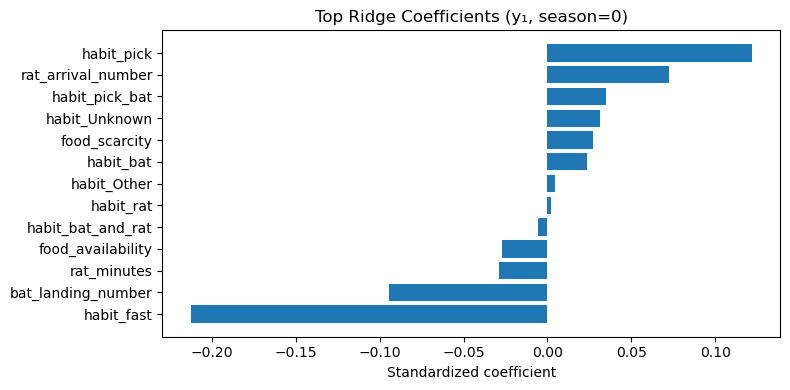

Saved: ./investigation_b_outputs/ridge_coefs_y1_season0.png


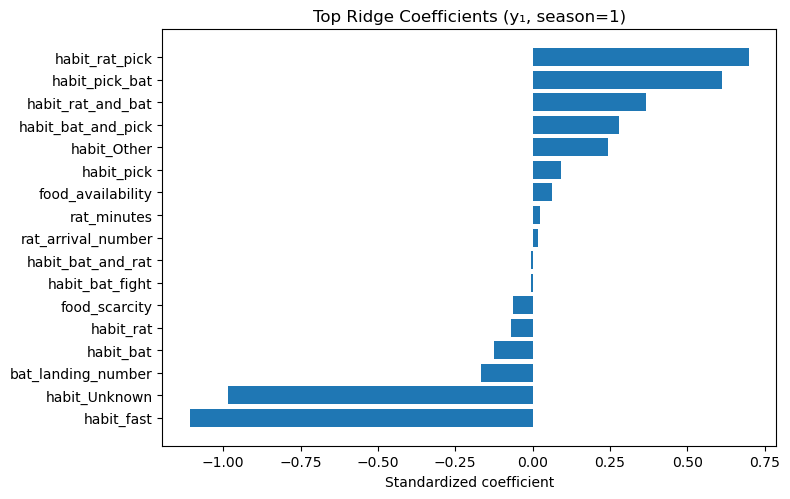

Saved: ./investigation_b_outputs/ridge_coefs_y1_season1.png


In [24]:

def feature_names_from_pipeline(pipeline, numeric_features, categorical_features):
    num_names = numeric_features
    if categorical_features:
        cat_encoder = pipeline.named_steps['preprocess'].named_transformers_['cat'].named_steps['onehot']
        cat_names = cat_encoder.get_feature_names_out(categorical_features).tolist()
    else:
        cat_names = []
    return list(num_names) + cat_names

for szn in models_y1.keys():
    ridge_model = models_y1[szn]['ridge']
    names = feature_names_from_pipeline(ridge_model, numeric_features, categorical_features)
    coefs = ridge_model.named_steps['model'].coef_
    dfc = pd.DataFrame({"feature": names, "coef": coefs}).sort_values("coef", ascending=False)
    topn = min(20, dfc.shape[0])
    dfc_top = dfc.head(topn)

    plt.figure(figsize=(8, max(4, topn*0.3)))
    plt.barh(dfc_top['feature'][::-1], dfc_top['coef'][::-1])
    plt.title(f"Top Ridge Coefficients (y₁, season={szn})")
    plt.xlabel("Standardized coefficient")
    plt.tight_layout()
    # Optionally save:
    fig_path = os.path.join(OUTPUT_DIR, f"ridge_coefs_y1_season{szn}.png")
    plt.savefig(fig_path, dpi=150, bbox_inches='tight')
    plt.show()
    print("Saved:", fig_path)


In [30]:
results = []

def compute_metrics(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    rmse = math.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    return r2, rmse, mae

# Fetch models and test splits
winter_model = models_y2[0]['ridge']   # Ridge Winter
spring_model = models_y2[1]['ridge']   # Ridge Spring

# Winter splits
df_train_w, df_val_w, df_test_w = models_y2[0]['splits']
y_test_w = np.log1p(df_test_w['bat_activity_intensity'].astype(float))

# Spring splits
df_train_s, df_val_s, df_test_s = models_y2[1]['splits']
y_test_s = np.log1p(df_test_s['bat_activity_intensity'].astype(float))


# In-Season Testing (model tested on its own season)
y_pred_w_on_w = winter_model.predict(df_test_w)
y_pred_s_on_s = spring_model.predict(df_test_s)

r2_ww, rmse_ww, mae_ww = compute_metrics(y_test_w, y_pred_w_on_w)
r2_ss, rmse_ss, mae_ss = compute_metrics(y_test_s, y_pred_s_on_s)

results.append(["Winter model on Winter data", r2_ww, rmse_ww, mae_ww])
results.append(["Spring model on Spring data", r2_ss, rmse_ss, mae_ss])

# Cross-Season Testing (swap test datasets)
y_pred_w_on_s = winter_model.predict(df_test_s)
y_pred_s_on_w = spring_model.predict(df_test_w)

r2_ws, rmse_ws, mae_ws = compute_metrics(y_test_s, y_pred_w_on_s)
r2_sw, rmse_sw, mae_sw = compute_metrics(y_test_w, y_pred_s_on_w)

results.append(["Winter model on Spring data", r2_ws, rmse_ws, mae_ws])
results.append(["Spring model on Winter data", r2_sw, rmse_sw, mae_sw])


# Display results
cross_df = pd.DataFrame(results, columns=["Model/Test Context", "R²", "RMSE", "MAE"])
cross_df = cross_df.sort_values(by="R²", ascending=False).reset_index(drop=True)
display(cross_df)


,Model/Test Context,R²,RMSE,MAE
0,Winter model on Spring data,0.917021,0.079509,0.056256
1,Spring model on Spring data,0.897319,0.088446,0.072067
2,Winter model on Winter data,0.767591,0.079905,0.055494
3,Spring model on Winter data,0.282772,0.140371,0.098924


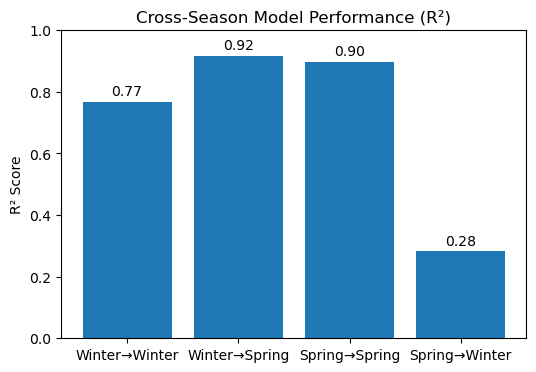

In [31]:
import matplotlib.pyplot as plt

labels = [
    "Winter→Winter",
    "Winter→Spring",
    "Spring→Spring",
    "Spring→Winter"
]
r2_values = [0.768, 0.917, 0.897, 0.283]

plt.figure(figsize=(6,4))
bars = plt.bar(labels, r2_values)
plt.title("Cross-Season Model Performance (R²)")
plt.ylabel("R² Score")
plt.ylim(0,1)
for bar, val in zip(bars, r2_values):
    plt.text(bar.get_x() + bar.get_width()/2, val + 0.02, f"{val:.2f}", ha='center')
plt.show()


Investigation A (Revisited)

In [19]:
y = merged['bat_activity_intensity']
X = merged[['rat_minutes', 'rat_arrival_number',
    'bat_landing_number', 'bat_landing_to_food',
    'food_availability', 'food_scarcity', 'food_scaled_01',
    'risk', 'reward', 'hours_after_sunset_x', 'season']]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model — Ridge Regression (balances bias/variance)
model_a = Ridge(alpha=10.0)
model_a.fit(X_train, y_train)

# Predictions
y_pred = model_a.predict(X_test)

# Metrics
r2 = r2_score(y_test, y_pred)
rmse = math.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f"R²: {r2:.3f}, RMSE: {rmse:.3f}, MAE: {mae:.3f}")

# Coefficients
coef_df = pd.DataFrame({'Variable': X.columns, 'Coefficient': model_a.coef_})
display(coef_df)


R²: 0.941, RMSE: 0.180, MAE: 0.129


,Variable,Coefficient
0,rat_minutes,-0.121803
1,rat_arrival_number,-0.011857
2,bat_landing_number,0.019110
3,bat_landing_to_food,-0.000030
4,food_availability,0.028257
5,food_scarcity,-0.007064
6,food_scaled_01,0.007064
7,risk,-0.000207
8,reward,0.007052
9,hours_after_sunset_x,0.001558


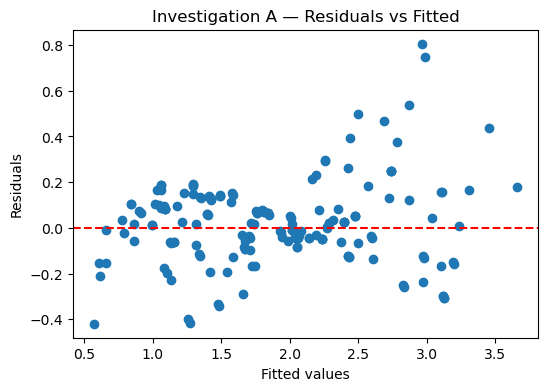

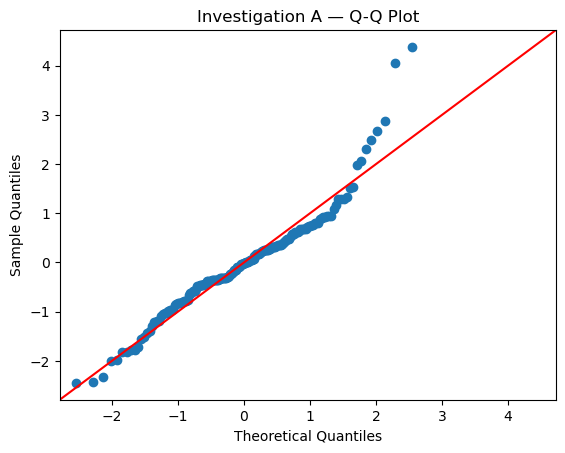

In [21]:
# Residuals
residuals = y_test - y_pred

# Residual vs Fitted
plt.figure(figsize=(6,4))
plt.scatter(y_pred, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title("Investigation A — Residuals vs Fitted")
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.show()

# Q-Q Plot
sm.qqplot(residuals, line='45', fit=True)
plt.title("Investigation A — Q-Q Plot")
plt.show()